In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.regressors import CoxPH, RSF, DeepSurv, DSM, BNNmcd
from tools.feature_selectors import NoneSelector, PHSelector
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
import config as cfg
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times

global DATASET
global N_BEARING
global TEST_SIZE
global TRAIN_SIZE
global N_SPLITS
global N_CONDITION    
global TYPE
global MERGE
global CENSORING
global N_BOOT

NEW_DATASET = True
DATASET = "xjtu"
TYPE = "bootstrap"  # not_correlated
CONDITION_SELECTOR = 0 # 0, 1, 2
PERCENTAGE = 0.1
TEST_SIZE = 0.3
N_CONDITION = len(cfg.RAW_DATA_PATH_XJTU)

if TYPE == "bootstrap":
    N_BOOT = 8
    cfg.DATA_TYPE = "bootstrap"
else:
    N_BOOT = 3
    cfg.DATA_TYPE = "not_bootstrap"

data_path = cfg.RAW_DATA_PATH_XJTU
N_CONDITION = len(data_path)
N_BEARING = cfg.N_REAL_BEARING_XJTU
N_SPLITS = 5
TRAIN_SIZE = 1
CENSORING = cfg.CENSORING_LEVEL

In [2]:
#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)

survival = Survival()
data_util = DataETL(DATASET, N_BOOT)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for test_cond in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(test_cond, N_BOOT)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
for test_cond, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
    # Create different data for bootstrap and not bootstrap
    if TYPE == "bootstrap":
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_bootstrap(cov, boot, info_pack, N_BOOT)
    else:
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_upsampling(cov, boot, info_pack, N_BOOT, TYPE)
    data_container_X.append(data_temp_X)
    data_container_y.append(deltaref_temp_y)

For bearing #61, event considered at the end of the recording


In [3]:
#Load information from the dataset selected in the config file
X = data_container_X[CONDITION_SELECTOR]
y = data_container_y[CONDITION_SELECTOR]

#Information about the event estimation in event detector
y_delta = y
print ("The event detector established an event for each bearing at:", y_delta)

data_X = []
for data_group in X:   
    data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
    data_X.append(data_temp_X)
X = data_X

#Indexing the dataset to avoid train/test leaking
bearing_idx = list(range(0, N_BEARING))

#Test/train split
train_idx, test_idx, _, _= train_test_split(bearing_idx, bearing_idx, shuffle=False, test_size=TEST_SIZE, random_state=0)
data_X_merge_tr = pd.DataFrame()
data_X_merge_te = pd.DataFrame()
for element in train_idx:
    data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
for element in test_idx:
    data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)
    
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Set up the models on test
params = DeepSurv().get_best_hyperparams()
model = DeepSurv().make_model(params)

#Format the data for NNs models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

#Make models
cph_model = CoxPH().make_model()
rsf_model = RSF().make_model()
deep_surv_model = DeepSurv().make_model()
dsm_model = DSM().make_model()
bnn_model = BNNmcd().make_model()

#Train model
deepsurv_params = DeepSurv().get_best_hyperparams()
dsm_params = DSM().get_best_hyperparams()
cph_model.fit(X_train_scaled, y_train)
rsf_model.fit(X_train_scaled, y_train)
deep_surv_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                    iters=deepsurv_params['iters'],
                    learning_rate=deepsurv_params['learning_rate'],
                    batch_size=deepsurv_params['batch_size'])
dsm_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
              iters=deepsurv_params['iters'],
              learning_rate=deepsurv_params['learning_rate'],
              batch_size=deepsurv_params['batch_size'])
bnn_model.fit(X_train_scaled, t_train, e_train)

#Predict
cph_surv_func = survival.predict_survival_function(cph_model, X_test_scaled, event_times)
rsf_surv_func = survival.predict_survival_function(rsf_model, X_test_scaled, event_times)
deep_surv_surv_func = survival.predict_survival_function(deep_surv_model, X_test_scaled, event_times)
dsm_surv_func = survival.predict_survival_function(dsm_model, X_test_scaled, event_times)
bnn_surv_func = survival.predict_survival_function(bnn_model, X_test_scaled, event_times)
km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                        y_test['Event'].reshape(1,-1),
                                                        event_times)

The event detector established an event for each bearing at: {1: 70.0, 21: 55.0, 41: 120.0, 61: 110.0, 81: 10.0}


100%|██████████| 100/100 [00:01<00:00, 93.01it/s]


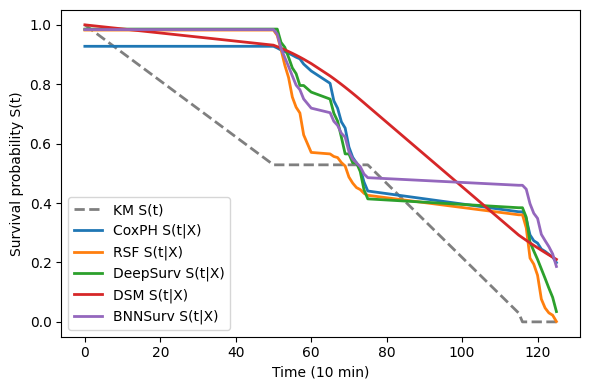

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, label="KM S(t)", color="black")
plt.plot(event_times, np.mean(cph_surv_func, axis=0), label="CoxPH S(t|X)", color="C0", linewidth=2)
plt.plot(event_times, np.mean(rsf_surv_func, axis=0), label="RSF S(t|X)", color="C1", linewidth=2)
plt.plot(event_times, np.mean(deep_surv_surv_func, axis=0), label="DeepSurv S(t|X)", color="C2", linewidth=2)
plt.plot(event_times, np.mean(dsm_surv_func, axis=0), label="DSM S(t|X)", color="C3", linewidth=2)
plt.plot(event_times, np.mean(bnn_surv_func, axis=0), label="BNNSurv S(t|X)", color="C4", linewidth=2)
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.tight_layout()
plt.legend()
plt.show()

The event detector established an event for each bearing at: {1: 70.0, 11: 55.0, 21: 120.0, 31: 110.0, 41: 10.0}


100%|██████████| 1/1 [00:00<00:00, 83.32it/s]


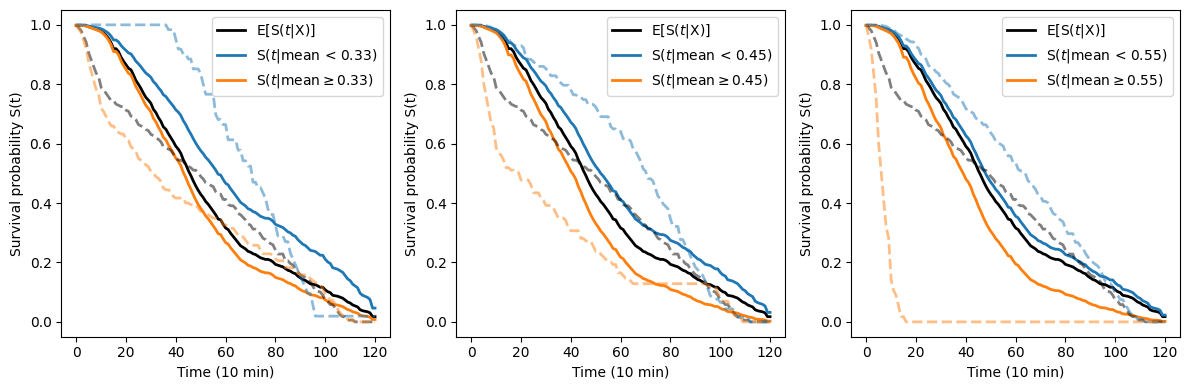

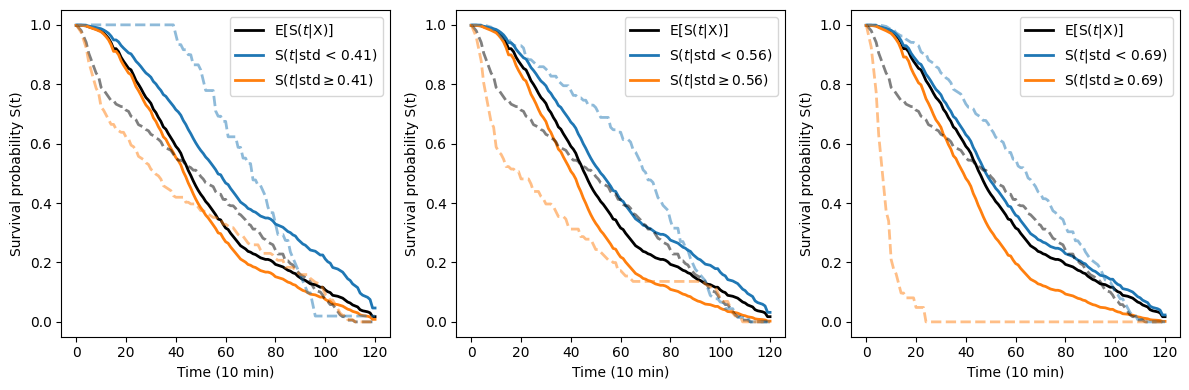

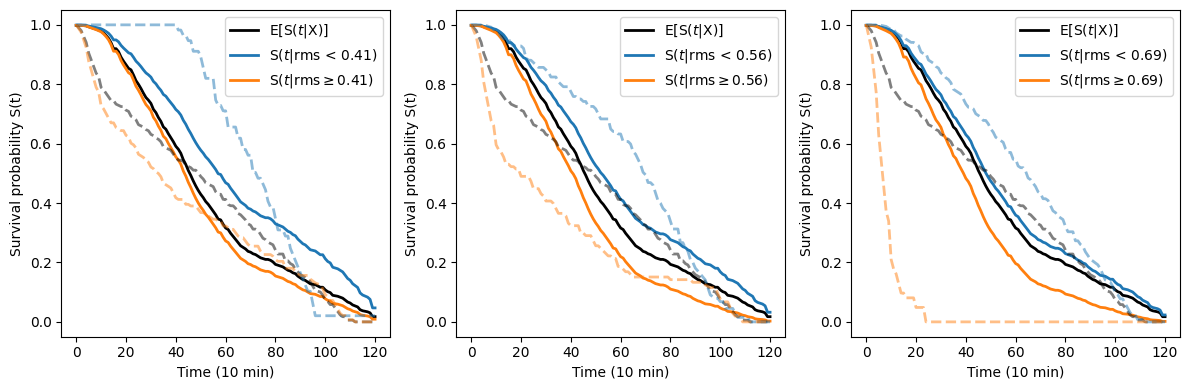

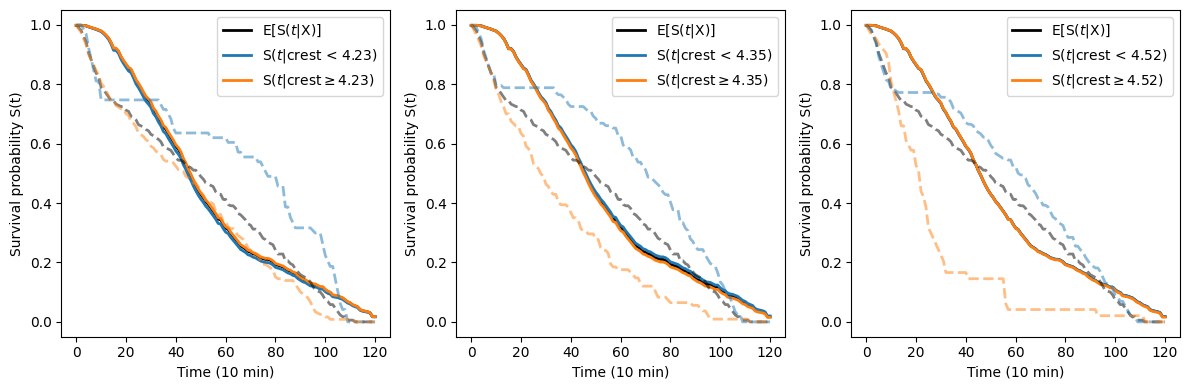

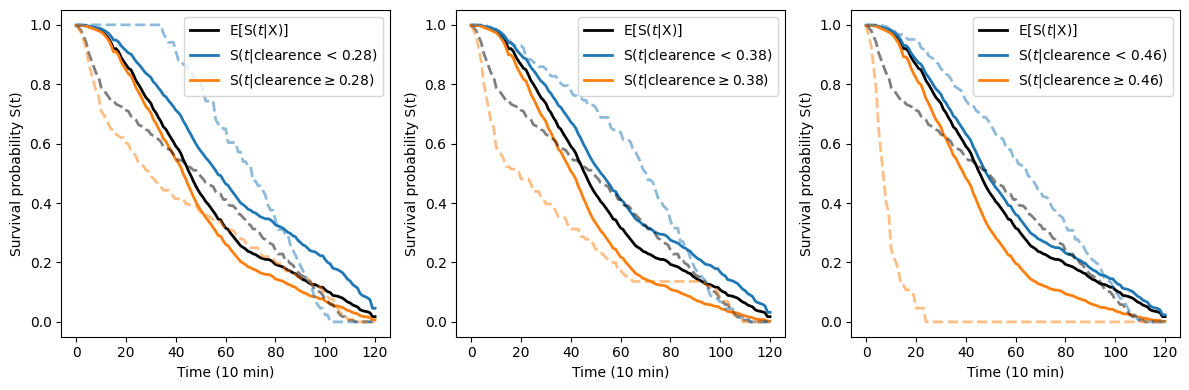

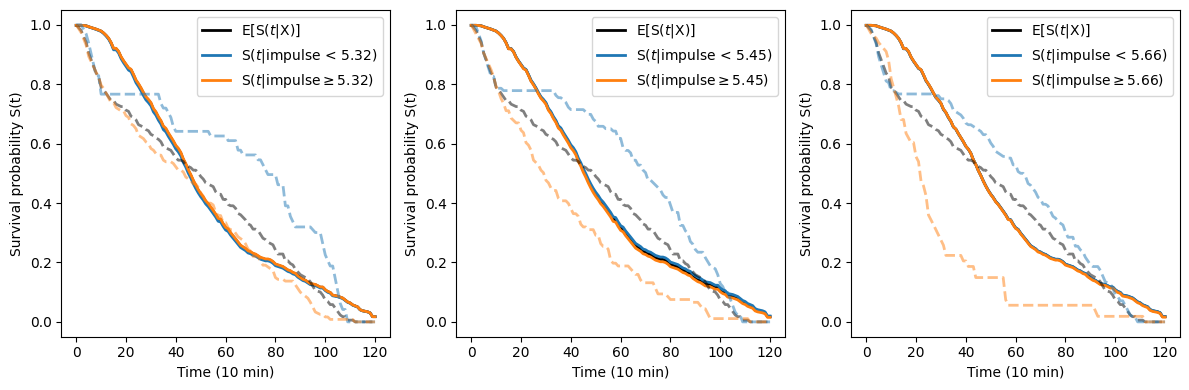

In [3]:
#Load information from the dataset selected in the config file
X = data_container_X[CONDITION_SELECTOR]
y = data_container_y[CONDITION_SELECTOR]

#Information about the event estimation in event detector
y_delta = y
print ("The event detector established an event for each bearing at:", y_delta)

data_X = []
for data_group in X:   
    data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
    data_X.append(data_temp_X)
X = data_X

#Indexing the dataset to avoid train/test leaking
bearing_idx = list(range(0, N_BEARING))

#Test/train split
train_idx, test_idx, _, _= train_test_split(bearing_idx, bearing_idx, shuffle=False, test_size=TEST_SIZE, random_state=0)
data_X_merge_tr = pd.DataFrame()
data_X_merge_te = pd.DataFrame()
for element in train_idx:
    data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
for element in test_idx:
    data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)
    
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

# Scale train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

#Set up the models on test
params = DeepSurv().get_best_hyperparams()
model = DeepSurv().make_model(params)

#Format the data for NNs models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

# Train the models and get the calculation time for each
#model.fit(X_train, y_train)
model.fit(X_train_scaled, t_train, e_train)

# Split data
features_to_split = best_features
for feature in features_to_split:
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test.loc[X_test[feature] < st].index
        g2_idx = X_test.loc[X_test[feature] >= st].index
        X_test_g1 = X_test.loc[g1_idx]
        X_test_g2 = X_test.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = scaler.transform(X_test)
        X_test_g1_scaled = scaler.transform(X_test_g1)
        X_test_g2_scaled = scaler.transform(X_test_g2)

        # Predict for mean and two groups
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, X_test_g1_scaled, event_times)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, X_test_g2_scaled, event_times)
        km_mean_g2, km_high_g2, km_low_g2 = calculate_kaplan_vectorized(y_test_g2['Survival_time'].reshape(1,-1),
                                                                        y_test_g2['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label="E[S($t$|X)]", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=f'S($t$|{feature} < {st})', color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=f'S($t$|{feature}$\geq${st})', color="C1")
        axes[i].plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, color="black")
        axes[i].plot(km_mean_g1.columns, km_mean_g1.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C0")
        axes[i].plot(km_mean_g2.columns, km_mean_g2.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C1")
        axes[i].set_xlabel("Time (10 min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        fig.tight_layout()
        fig.show()

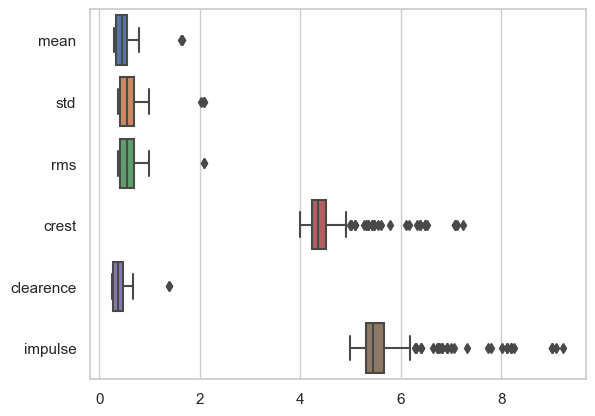

In [4]:
# Plot test data
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
sns.set()
sns.set_style("whitegrid")
sns.boxplot(data=X_test, orient= "h") # notch=True
plt.show()

In [5]:
y_delta

{1: 70.0, 11: 55.0, 21: 120.0, 31: 110.0, 41: 10.0}

{1: 70.0, 11: 55.0, 21: 120.0, 31: 110.0, 41: 10.0}


100%|██████████| 1/1 [00:00<00:00, 142.83it/s]


{1: 410.0, 11: 120.0, 21: 310.0, 31: 20.0, 41: 175.9}


100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


{1: 1050.0, 11: 370.0, 21: 330.0, 31: 630.0, 41: 90.0}


100%|██████████| 1/1 [00:00<00:00, 153.83it/s]


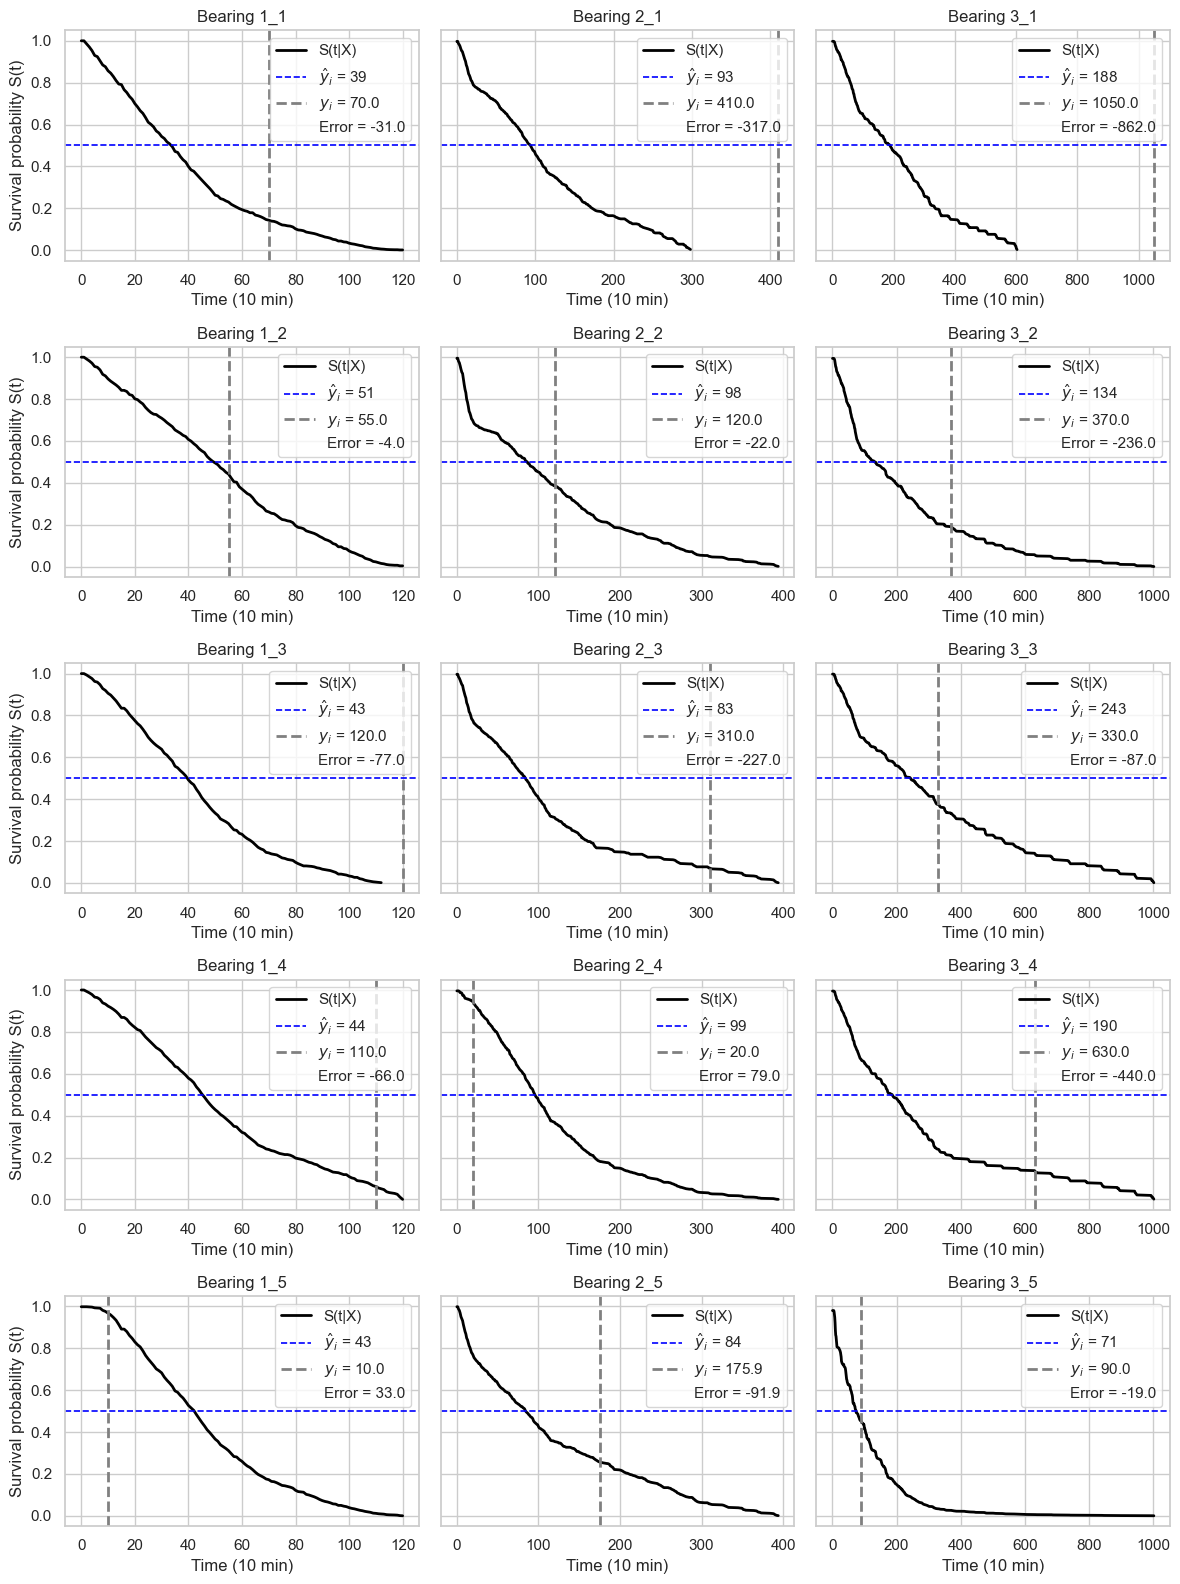

In [37]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(5, 3, figsize=(12,16), sharey=True)
for cond in [0, 1, 2]:
    # Load data
    X = data_container_X[cond]
    y = data_container_y[cond]
    print(y)

    data_X = []
    for data_group in X:   
        data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
        data_X.append(data_temp_X)
    X = data_X

    # Individual bearing prediction
    bearings = np.arange(0, N_BEARING)
    for idx in bearings:
        train_idx = bearings[np.arange(len(bearings))!=idx]
        test_idx = bearings[idx]
        
        X_train_merged = pd.DataFrame()
        for element in train_idx:
            X_train_merged = pd.concat([X_train_merged, X[element]], ignore_index=True)
        X_test_merged = pd.DataFrame(X[test_idx])
        
        # Select only first observation
        X_test_merged = X_test_merged[X_test_merged['Survival_time'] == X_test_merged['Survival_time'].max()] \
                        .drop_duplicates(subset="Survival_time")
        
        # Format data
        X_train = X_train_merged.drop(['Event', 'Survival_time'], axis=1)
        X_test = X_test_merged.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", X_train_merged)
        y_test = Surv.from_dataframe("Event", "Survival_time", X_test_merged)
        failure_time = list(y.values())[idx]
        features = list(X_train.columns)
        
        #Set event times for general models and only NNs
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
        X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

        # Scale train data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        #Set up the models on test
        params = DeepSurv().get_best_hyperparams()
        model = DeepSurv().make_model(params)

        #Format the data for NNs models
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']

        # Train the models and get the calculation time for each
        model.fit(X_train_scaled, t_train, e_train)
        
        # Predict
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times)
        surv_probs = surv_probs.fillna(0)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(surv_probs.T, t_test, e_test, t_train, e_train)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        mae = lifelines_eval.mae(method="Hinge")
        
        # Plot
        p1 = axes[idx, cond].plot(np.mean(surv_probs, axis=0).T, linewidth=2, label="S(t|X)", color="black")
        p2 = axes[idx, cond].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1.2, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[idx, cond].axvline(x=failure_time, linestyle= "dashed", color='gray', linewidth=2.0, label=f'$y_i$ = {failure_time}')
        axes[idx, cond].set_title(f'Bearing {cond+1}_{idx+1}')
        axes[idx, cond].set_xlabel("Time (10 min)")
        text = f'Error = {median_survival_time-failure_time}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[idx, cond].legend([p1[0], p2, p3, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text], loc='upper right')
        if cond == 0:
            axes[idx, cond].set_ylabel("Survival probability S(t)")
plt.tight_layout()

In [39]:
data_container_y

[{1: 70.0, 11: 55.0, 21: 120.0, 31: 110.0, 41: 10.0},
 {1: 410.0, 11: 120.0, 21: 310.0, 31: 20.0, 41: 175.9},
 {1: 1050.0, 11: 370.0, 21: 330.0, 31: 630.0, 41: 90.0}]